# Text Classification: Classify Faculty from Chula courses description

## Import libraries and Data

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# ## Uncomment if used in Google Colab
# !git init .
# !git remote add origin https://github.com/new5558/Chula-course-recommender-proof-of-concept
# !git pull origin master
# !pip install -r requirements.txt
# !pip install thai2transformers==0.1.2 --no-dependencies

In [3]:
!pip install emoji

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Dec  4 19:50:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
# !pip install transformers langdetect scikit-optimize sentencepiece

In [7]:
import pandas as pd
from langdetect import detect
from tqdm import tqdm
from tqdm.autonotebook import tqdm

import multiprocessing as mp
import skopt
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn import svm
import json

from thai2transformers.preprocess import process_transformers
import torch

tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


In [8]:
import os
os.getcwd()

'/content'

In [9]:
dtype_dic= {'course_no': str, 'program_code': str}

courses_df = pd.read_csv('./data/course_chula_full-11262021.csv', index_col=0)
program_courses_thai_df = pd.read_csv('./data/program_courses_thai.csv', dtype=dtype_dic, index_col=0)

In [10]:
courses_df

,course_no,course_name,course_abberviation,description,course_name_thai,description_thai
0,0123100,Thai Writing in Workplace,THAI WRIT WORK,"Principles, formats and methods of writing Tha...",การเขียนภาษาไทยในที่ทำงาน,หลักเกณฑ์ รูปแบบ และวิธีการเขียนงานเอกสารภาษาไ...
1,0123101,Paragraph Writing,PARAGRAP WRITING,Organizing ideas in paragraph writing; selecti...,การเขียนย่อหน้า,การเรียงลำดับความคิดในการเขียนย่อหน้า การเลือก...
2,0123102,Language in Report Writing,LANG REP WRIT,"Academic report structures, footnotes and bibl...",ภาษาในการเขียนรายงาน,โครงสร้างรายงานทางวิชาการ เชิงอรรถ และบรรณานุก...
3,0123103,Proposal Writing,PROPOSAL WRITING,Writing various types of proposals with emphas...,การเขียนโครงการ,โครงสร้างโครงการแบบต่างๆ โดยใช้ภาษาที่ชัดเจนแล...
4,0123104,University Level of Thai Reading,UNIV THAI READING,Reading principles; levels of reading; main id...,การอ่านภาษาไทยระดับอุดมศึกษา,หลักการอ่าน ระดับของการอ่าน การจับใจความ การตี...
...,...,...,...,...,...,...
25249,6303620,Petroleum Exploration and Production,PETROL EXPLO PROD,Petroleum geology; petroleum exploration and g...,การสำรวจและการผลิตปิโตรเลียม,ธรณีวิทยาปิโตรเลียม การสำรวจปิโตรเลียมและธรณีฟ...
25250,6303621,PETROL BUS,-,Petroleum industry and refinery; economics; ch...,ธุรกิจปิโตรเลียม: โครงสร้าง โลจิสติกส์ และเศรษ...,อุตสาหกรรมปิโตรเลียมและการกลั่นน้ำมัน เศรษฐศาส...
25251,6303622,Advances in Petroleum Technology,ADV PETROL TECH,Discussions on special topics related to advan...,ความก้าวหน้าด้านเทคโนโลยีปิโตรเลียม,การอภิปรายหัวข้อพิเศษที่เกี่ยวข้องกับความก้าวห...
25252,6303623,Selected Topics in Oil and Gas Production,SEL OIL GAS,Various aspects related to the new and up to d...,วิชาเลือกเฉพาะด้านในการผลิตน้ำมันดิบและก๊าซธรร...,เนื้อหาวิชาครอบคลุม พัฒนาการและความเปลี่ยนแปลง...


In [11]:
program_courses_thai_df

,tag,course_no,program_code
0,กลุ่มวิชาภาษาต่างประเทศ,5501112,121001
1,กลุ่มวิชาภาษาต่างประเทศ,5501123,121001
2,กลุ่มวิชาภาษาต่างประเทศ,5501214,121001
3,กลุ่มวิชาภาษาต่างประเทศ,5501225,121001
4,กลุ่มวิชาศึกษาทั่วไปกลุ่มพิเศษ,2140111,121001
...,...,...,...
25570,วิทยานิพนธ์,6302828,563001
25573,รายวิชาบังคับเลือก,6302601,563001
25574,รายวิชาบังคับเลือก,6302602,563001
25575,รายวิชาบังคับเลือก,6302603,563001


## Data Exploration

In [12]:
program_courses_thai_df['course_no'].apply(lambda x: len(str(x))).value_counts()

7    20607
Name: course_no, dtype: int64

In [13]:
program_courses_thai_df.dtypes

tag             object
course_no       object
program_code    object
dtype: object

In [14]:
courses_df.dtypes

course_no              object
course_name            object
course_abberviation    object
description            object
course_name_thai       object
description_thai       object
dtype: object

In [15]:
def detect_language(text):
  if text == '-':
    return text
  try:
    return detect(text)
  except:
    return 'err'

In [16]:
p = mp.Pool(mp.cpu_count())
description_thai_language = pd.Series(list(tqdm(p.imap(detect_language, courses_df['description_thai']), total = len(courses_df))), name="description_thai")

  0%|          | 0/25254 [00:00<?, ?it/s]

In [17]:
description_thai_language.value_counts()

th    22942
-      2298
de       11
en        3
Name: description_thai, dtype: int64

In [18]:
courses_df[(description_thai_language != 'th') & (description_thai_language != '-')]

,course_no,course_name,course_abberviation,description,course_name_thai,description_thai
386,2007894,DOCTORAL DISSERTATION SEMINAR,DOC DISS SEM,S/U,สัมมนาวิทยานิพนธ์ระดับดุษฎีบัณฑิต,S/U
424,2008896,Comprehensive Examination,COMPREHENSIVE EXAM,S/U,การสอบประมวลความรู้,S/U
517,2010897,QUALIFYING EXAMINATION,QUALIFYING EXAM,การสอบวัดคุณสมบัติ,การสอบวัดคุณสมบัติ,QUALIFYING EXAMINATION
546,2013811,THESIS,THESIS,-,วิทยานิพนธ์,S/U
2531,2109520,PHYSICAL CERAMICS,PHY CERAMICS,Physical and chemical process responsible for ...,เซรามิกกายภาพ,Physical and chemical process responsible for ...
4937,2208896,COMPREHENSIVE EXAMINATION,COM EXAM,S/U,สอบประมวลความรู้,S/U
5920,2231841,SEMINAR IN FRENCH LANGUAGE AND LITERATURE I,SEM FR LANG LIT I,S/U,สัมมนาภาษาและวรรณคดีฝรั่งเศส 1,S/U
5921,2231842,SEMINAR IN FRENCH LANGUAGE AND LITERATURE II,SEM FE LAND LIT II,S/U,สัมมนาภาษาและวรรณคดีฝรั่งเศส 2,S/U
5922,2231894,DOCTORAL DISSERTATION SEMINAR,DOC DISS SEM,S/U,สัมมนาวิทยานิพนธ์ระดับดุษฎีบัณฑิต,S/U
10515,2600896,COMPREHENSIVE EXAMINIATION,COMPREHENSIVE EXAM,(S/U),การสอบประมวลความรู้,S/U


In [19]:
courses_df.iloc[17405]['description_thai']

'ภาวะเร่งด่วนทางศัลยศาสตร์อุบัติเหตุ การบาดเจ็บที่พบบ่อย กลไกการบาดเจ็บ การประเมิน การวินิจฉัย \r\nและการดูแลผู้บาดเจ็บเบื้องต้น หัตถการในการดูแลผู้บาดเจ็บ การผ่าตัดผู้บาดเจ็บจากอุบัติเหตุ หลักการและ \r\nแนวคิดในการดูแลผู้บาดเจ็บจากอุบัติเหตุ'

In [20]:
p = mp.Pool(mp.cpu_count())
course_name_thai_language = pd.Series(list(tqdm(p.imap(detect_language, courses_df['course_name_thai']), total = len(courses_df))), name="course_name_thai")

  0%|          | 0/25254 [00:00<?, ?it/s]

In [21]:
course_name_thai_language.value_counts()

th    24633
-       619
en        2
Name: course_name_thai, dtype: int64

In [22]:
courses_df[(course_name_thai_language != 'th') & (course_name_thai_language != '-')]

,course_no,course_name,course_abberviation,description,course_name_thai,description_thai
766,2023505,ENGY CONSERV IND,การอนุรักษ์พลังงานในภาคอุตสาหกรรม,Principles and process of energy conservation ...,Energy Conservation in Industry,หลักการและกระบวนการในการดำเนินการอนุรักษ์พลังง...
21744,3341711,PHARMACEUTICAL CHEMISTRY AND NATURAL PRODUCTS ...,-,Oral presentation and discussion of selected a...,PH CHM NAT SEM II,-


## Clean Data

In [23]:
courses_df_clean = courses_df[((description_thai_language == 'th') & (course_name_thai_language == 'th'))]

In [24]:
courses_df_clean

,course_no,course_name,course_abberviation,description,course_name_thai,description_thai
0,0123100,Thai Writing in Workplace,THAI WRIT WORK,"Principles, formats and methods of writing Tha...",การเขียนภาษาไทยในที่ทำงาน,หลักเกณฑ์ รูปแบบ และวิธีการเขียนงานเอกสารภาษาไ...
1,0123101,Paragraph Writing,PARAGRAP WRITING,Organizing ideas in paragraph writing; selecti...,การเขียนย่อหน้า,การเรียงลำดับความคิดในการเขียนย่อหน้า การเลือก...
2,0123102,Language in Report Writing,LANG REP WRIT,"Academic report structures, footnotes and bibl...",ภาษาในการเขียนรายงาน,โครงสร้างรายงานทางวิชาการ เชิงอรรถ และบรรณานุก...
3,0123103,Proposal Writing,PROPOSAL WRITING,Writing various types of proposals with emphas...,การเขียนโครงการ,โครงสร้างโครงการแบบต่างๆ โดยใช้ภาษาที่ชัดเจนแล...
4,0123104,University Level of Thai Reading,UNIV THAI READING,Reading principles; levels of reading; main id...,การอ่านภาษาไทยระดับอุดมศึกษา,หลักการอ่าน ระดับของการอ่าน การจับใจความ การตี...
...,...,...,...,...,...,...
25249,6303620,Petroleum Exploration and Production,PETROL EXPLO PROD,Petroleum geology; petroleum exploration and g...,การสำรวจและการผลิตปิโตรเลียม,ธรณีวิทยาปิโตรเลียม การสำรวจปิโตรเลียมและธรณีฟ...
25250,6303621,PETROL BUS,-,Petroleum industry and refinery; economics; ch...,ธุรกิจปิโตรเลียม: โครงสร้าง โลจิสติกส์ และเศรษ...,อุตสาหกรรมปิโตรเลียมและการกลั่นน้ำมัน เศรษฐศาส...
25251,6303622,Advances in Petroleum Technology,ADV PETROL TECH,Discussions on special topics related to advan...,ความก้าวหน้าด้านเทคโนโลยีปิโตรเลียม,การอภิปรายหัวข้อพิเศษที่เกี่ยวข้องกับความก้าวห...
25252,6303623,Selected Topics in Oil and Gas Production,SEL OIL GAS,Various aspects related to the new and up to d...,วิชาเลือกเฉพาะด้านในการผลิตน้ำมันดิบและก๊าซธรร...,เนื้อหาวิชาครอบคลุม พัฒนาการและความเปลี่ยนแปลง...


## Data transformation

In [25]:
df_faculty = courses_df_clean[['course_no', 'course_name_thai', 'description_thai']]

In [26]:
course_no_len = df_faculty['course_no'].apply(lambda x: len(x))

In [27]:
course_no_len.value_counts()

7    22895
6       41
4        1
Name: course_no, dtype: int64

In [28]:
df_faculty[course_no_len == 6]

,course_no,course_name_thai,description_thai
308,200614,การจัดการบริการผู้โดยสาร,การบริการผู้โดยสาร การบริการในห้องรับรองผู้โดย...
736,202169,เคมีสำหรับนิสิตแพทย์,เทอร์โมไดนามิกส์ สมดุลเคมี จลนพลศาสตร์เคมี โคร...
1736,210443,ออโตเมชัน,แนวคิดพื้นฐานเกี่ยวกับระบบออโตเมชันในอุตสาหกรร...
1997,210564,วิศวกรรมของวัสดุที่ย่อยสลายได้ทางชีวภาพ,ประเภทของวัสดุที่ย่อยสลายได้ทางชีวภาพทั้งวัสดุ...
2336,210794,การผลิตน้ำใช้และการบำบัดน้ำเสียในอุตสาหกรรม,แหล่งของน้ำใช้ มาตรฐานของน้ำในอุตสาหกรรมเทคนิค...
3029,213225,ปฏิบัติการวัดความดำ,ปฏิบัติการเกี่ยวกับการวัดแสง การวัดความดำ การ...
3408,218220,วิธีเชิงคณิตศาสตร์ขั้นสูง,การวิเคราะห์เชิงซ้อนซึ่งประกอบด้วยฟังก์ชันของต...
3418,218228,สิ่งประดิษฐ์สารกึ่งตัวนำ 1,สมบัติของผลึกและการปลูกผลึกสารกึ่งตัวนำ อะตอมแ...
3432,218244,อิเล็กทรอนิกส์ชีวแพทย์,สัญญาณไฟฟ้าในร่างกายมนุษย์ ศักย์กระทำในเซลล์ อ...
3445,218248,สิ่งประดิษฐ์สารกึ่งตัวนำ 2,การทบทวนฟิสิกส์และสมบัติของสารกึ่งตัวนำ สารประ...


In [29]:
df_faculty = df_faculty[course_no_len == 7]

In [30]:
faculty_no = df_faculty['course_no'].apply(lambda x: x[:2])
faculty_no

0        01
1        01
2        01
3        01
4        01
         ..
25249    63
25250    63
25251    63
25252    63
25253    63
Name: course_no, Length: 22895, dtype: object

In [31]:
faculty_no_counts = faculty_no.value_counts()
faculty_no_counts

30    2652
22    2614
21    2453
27    2407
23    2037
33    1015
32    1011
28     987
31     941
26     907
25     844
24     638
20     605
37     577
34     525
38     507
29     496
39     463
35     397
36     232
55     118
53     118
63      96
02      92
51      81
40      59
56      13
01       7
48       1
60       1
58       1
Name: course_no, dtype: int64

In [32]:
faculty_more_than_50 = faculty_no_counts[faculty_no_counts > 50].index
faculty_more_than_50

Index(['30', '22', '21', '27', '23', '33', '32', '28', '31', '26', '25', '24',
       '20', '37', '34', '38', '29', '39', '35', '36', '55', '53', '63', '02',
       '51', '40'],
      dtype='object')

In [33]:
df_faculty['faculty_no'] = faculty_no

In [34]:
df_faculty = df_faculty[df_faculty['faculty_no'].isin(faculty_more_than_50)]

In [35]:
df_faculty

,course_no,course_name_thai,description_thai,faculty_no
7,0201101,การศึกษาทั่วไปเรื่องอัญมณีและเครื่องประดับ,พลอยสำคัญ แหล่งที่กำเนิด คุณสมบัติ ลักษณะเฉพาะ...,02
8,0201102,ภูมิปัญญาไทย,การศึกษาด้วยตนเอง วิธีการวิเคราะห์และสังเคราะห...,02
9,0201103,จุฬาฯ ของเรา,ประวัติความเป็นมาของจุฬาลงกรณ์มหาวิทยาลัย บทบา...,02
10,0201104,การจัดการกับความเครียด,ความหมายของความเครียด ปัจจัยต่างๆ ทางธรรมชาติแ...,02
11,0201105,พุทธบัณฑิตจุฬาฯ สง่างาม,ประมวลแนวคำสอนหมวดใหญ่ๆ เกี่ยวกับพุทธศาสนาในปร...,02
...,...,...,...,...
25249,6303620,การสำรวจและการผลิตปิโตรเลียม,ธรณีวิทยาปิโตรเลียม การสำรวจปิโตรเลียมและธรณีฟ...,63
25250,6303621,ธุรกิจปิโตรเลียม: โครงสร้าง โลจิสติกส์ และเศรษ...,อุตสาหกรรมปิโตรเลียมและการกลั่นน้ำมัน เศรษฐศาส...,63
25251,6303622,ความก้าวหน้าด้านเทคโนโลยีปิโตรเลียม,การอภิปรายหัวข้อพิเศษที่เกี่ยวข้องกับความก้าวห...,63
25252,6303623,วิชาเลือกเฉพาะด้านในการผลิตน้ำมันดิบและก๊าซธรร...,เนื้อหาวิชาครอบคลุม พัฒนาการและความเปลี่ยนแปลง...,63


In [36]:
df = df_faculty

## Prepare data for each models

### Commons
Faculty: train_X_base, val_X_base, train_Y_text, val_Y_text

In [37]:
# df = pd.read_csv('./data/df_clean.csv')

In [38]:
from skopt.callbacks import CheckpointSaver
import time


class BayesianCallback(object):
    current = 0
    def __init__(self, total, start = 0, **kwargs):
        self.current = start
        self._checkpoint_saver = CheckpointSaver(**kwargs)
        self.total = total
    def __call__(self, res):
        self._checkpoint_saver.__call__(res)
        self.current += 1
        print(f"{self.current}/{self.total}")

# Backward compatible reason
class LifeSaver(object):
    current = 0
    def __init__(self, total, start = 0, **kwargs):
        self.current = start
        self._checkpoint_saver = CheckpointSaver(**kwargs)
        self.total = total
    def __call__(self, res):
        self._checkpoint_saver.__call__(res)
        self.current += 1
        print(f"{self.current}/{self.total}")


#### Faculty

In [39]:
Y_text = df['faculty_no'].values
Y_text

array(['02', '02', '02', ..., '63', '63', '63'], dtype=object)

In [40]:
X_base = df['description_thai']

In [41]:
train_X_base, val_X_base, train_Y_text, val_Y_text = train_test_split(X_base, Y_text, test_size=0.1, random_state=25, stratify=Y_text)

#### Program

In [42]:
program_courses_thai_df[program_courses_thai_df['course_no'] == '5501112']

,tag,course_no,program_code
0,กลุ่มวิชาภาษาต่างประเทศ,5501112,121001
67,กลุ่มวิชาภาษาต่างประเทศ,5501112,121002
135,กลุ่มวิชาภาษาต่างประเทศ,5501112,121003
191,กลุ่มวิชาภาษาต่างประเทศ,5501112,121004


In [43]:
import math

def get_program_from_course_no(course_no):
    result = program_courses_thai_df[program_courses_thai_df['course_no'] == course_no]['program_code'].drop_duplicates().values
    return result if len(result) != 0 else math.nan

In [44]:
Y_program = None

with mp.Pool(mp.cpu_count()) as p:
  Y_program = pd.Series(list(tqdm(p.imap(get_program_from_course_no, df['course_no']), total = len(df))))

  0%|          | 0/22872 [00:00<?, ?it/s]

In [45]:
Y_program = Y_program.dropna()

In [46]:
Y_program

0                                                 [123022]
12                                                [138001]
26       [128010, 128021, 128030, 128032, 128041, 12804...
51                                [123022, 126026, 126027]
131                                       [320030, 520031]
                               ...                        
22867                                             [363200]
22868                                             [363200]
22869                                             [363200]
22870                                             [363200]
22871                                             [363200]
Length: 11545, dtype: object

### WangChanBerta

In [47]:
# df.to_csv('./data/df_clean.csv')

In [48]:
model_name = "airesearch/wangchanberta-base-att-spm-uncased"
# #revision = "finetuned@wisesight_sentiment"
# revision = None
# model = AutoModelForSequenceClassification.from_pretrained(
#     model_name, num_labels=2, revision=revision
# )
tokenizer = AutoTokenizer.from_pretrained(
                model_name,
                revision='main',
                model_max_length=416,)

In [49]:
test_text = process_transformers("ความหมายและความสำคัญของครอบครัวในมุมมองด้านสังคมศาสตร์ มนุษยศาสตร์ และวิทยาศาสตร์ ปัจจัยเอื้อต่อความสัมพันธ์อันดีในครอบครัว กระบวนการการสร้างความสัมพันธภาพในครอบครัว การวิเคราะห์และคลี่คลายปัญหาครอบครัวจากมุมมองแบบองค์รวม")
tokenizer.tokenize(test_text)

['▁',
 'ความหมาย',
 'และความ',
 'สําคัญของ',
 'ครอบครัว',
 'ในมุมมอง',
 'ด้าน',
 'สังคม',
 'ศาสตร์',
 '<_>',
 '▁',
 'มนุษย',
 'ศาสตร์',
 '<_>',
 '▁และ',
 'วิทยา',
 'ศาสตร์',
 '<_>',
 '▁',
 'ปัจจัย',
 'เอื้อต่อ',
 'ความ',
 'สัมพันธ์',
 'อันดี',
 'ในครอบครัว',
 '<_>',
 '▁',
 'กระบวนการ',
 'การ',
 'สร้างความ',
 'สัมพันธภาพ',
 'ในครอบครัว',
 '<_>',
 '▁การ',
 'วิเคราะห์',
 'และ',
 'คลี่คลาย',
 'ปัญหา',
 'ครอบครัว',
 'จาก',
 'มุมมอง',
 'แบบ',
 'องค์',
 'รวม']

In [50]:
def tokenize_transformers(text):
  return tokenizer.tokenize(process_transformers(text))

description_token = None

with mp.Pool(mp.cpu_count()) as p:
  description_token = pd.Series(list(tqdm(p.imap(tokenize_transformers, train_X_base), total = len(train_X_base))))

  0%|          | 0/20584 [00:00<?, ?it/s]

In [51]:
description_token_count = description_token.apply(lambda x: len(x))

In [52]:
np.argmax(description_token_count)

13106

In [53]:
max(description_token_count)

406

In [54]:
a = train_X_base.iloc[1281]
a

'แนวคิดพื้นฐานเกี่ยวกับการบริหารจัดการห้องปฏิบัติการ ได้แก่ การบริหารองค์กร การบริหารเชิงกลยุทธ์ การบริหารทรัพยากรมนุษย์ การทำงานร่วมกับบุคลากรสหวิชาชีพ การบริหารการเงิน การบริหารพัสดุ การจัดการห่วงโซ่อุปทาน การจัดการคลังสินค้า การบริหารความเสี่ยง การออกแบบและจัดตั้งห้องปฏิบัติการทางการแพทย์ การวิเคราะห์การลื่นไหลของงาน ระบบสาธารณูปโภคที่เกี่ยวข้อง ระบบความปลอดภัยต่อบุคลากร ผู้ป่วย และของสิ่งแวดล้อม การบริหารคุณภาพ ระบบการจัดการสารสนเทศห้องปฏิบัติการ มาตรฐานและการรับรองคุณภาพห้องปฏิบัติการทางการแพทย์ เครื่องมือการบริหารจัดการ ได้แก่ บาลานซ์สกอร์การ์ด ลีน    ซิกซ์ซิกม่า แนวคิดในการพัฒนาบุคลากร องค์กรแห่งการเรียนรู้ และการบริหารความผูกพันของลูกค้า'

In [55]:
b = ''.join(description_token.iloc[1281][0:508]).replace('▁', '').strip()
b

'แนวคิดพื้นฐานเกี่ยวกับการบริหารจัดการห้องปฏิบัติการ<_>ได้แก่<_>การบริหารองค์กร<_>การบริหารเชิงกลยุทธ์<_>การบริหารทรัพยากรมนุษย์<_>การทํางานร่วมกับบุคลากรสหวิชาชีพ<_>การบริหารการเงิน<_>การบริหารพัสดุ<_>การจัดการห่วงโซ่อุปทาน<_>การจัดการคลังสินค้า<_>การบริหารความเสี่ยง<_>การออกแบบและจัดตั้งห้องปฏิบัติการทางการแพทย์<_>การวิเคราะห์การลื่นไหลของงาน<_>ระบบสาธารณูปโภคที่เกี่ยวข้อง<_>ระบบความปลอดภัยต่อบุคลากร<_>ผู้ป่วย<_>และของสิ่งแวดล้อม<_>การบริหารคุณภาพ<_>ระบบการจัดการสารสนเทศห้องปฏิบัติการ<_>มาตรฐานและการรับรองคุณภาพห้องปฏิบัติการทางการแพทย์<_>เครื่องมือการบริหารจัดการ<_>ได้แก่<_>บาลานซ์สกอร์การ์ด<_>ลีน<_>ซิกซ์ซิกม่า<_>แนวคิดในการพัฒนาบุคลากร<_>องค์กรแห่งการเรียนรู้<_>และการบริหารความผูกพันของลูกค้า'

In [56]:
class CourseDataset(torch.utils.data.Dataset):
    
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).type(torch.LongTensor)
        return item

    def __len__(self):
        return len(self.labels)

In [57]:
label_number = pd.Series(val_Y_text).nunique()
label_number

26

In [58]:
max_token_length = 508

def replace_long_sentence(text):
  return ''.join(tokenize_transformers(text)[0:max_token_length]).replace('▁', '').strip()


description_thai_train = None
description_thai_val = None

with mp.Pool(mp.cpu_count()) as p:
  description_thai_train = pd.Series(list(tqdm(p.imap(replace_long_sentence, train_X_base), total = len(train_X_base))))
  description_thai_val = pd.Series(list(tqdm(p.imap(replace_long_sentence, val_X_base), total = len(val_X_base))))

# description_thai_train = train_X_base.apply(replace_long_sentence)
# description_thai_val = val_X_base.apply(replace_long_sentence)

  0%|          | 0/20584 [00:00<?, ?it/s]

  0%|          | 0/2288 [00:00<?, ?it/s]

In [59]:
train_texts = description_thai_train.tolist()
val_texts = description_thai_val.tolist()

In [60]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

train_labels = enc.fit_transform(train_Y_text.reshape((-1, 1)))
val_labels = enc.fit_transform(val_Y_text.reshape((-1, 1)))

In [61]:
target_names = [str(number) for number in enc.categories_[0]]
target_names

['02',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '51',
 '53',
 '55',
 '63']

In [62]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [63]:
train_dataset = CourseDataset(train_encodings, train_labels)
val_dataset = CourseDataset(val_encodings, val_labels)

In [64]:
print(len(train_dataset))
print(len(val_dataset))

20584
2288


### Tokenize word

In [ ]:
from pythainlp import word_tokenize

print("no whitespace:", word_tokenize(val_X_base.iloc[0], keep_whitespace=False))

In [ ]:
def tokenize_word(text):
  return word_tokenize(text, keep_whitespace=False)

description_thai_tokenize_train = train_X_base.progress_apply(tokenize_word)
description_thai_tokenize_val = val_X_base.progress_apply(tokenize_word)
description_thai_tokenize_train

In [ ]:
description_thai_word_count = description_thai_tokenize_train.apply(lambda x: len(x))

In [ ]:
description_thai_word_count.value_counts()

In [ ]:
print(description_thai_word_count.mean())
print(description_thai_word_count.median())
print(description_thai_word_count.max())
print(description_thai_word_count.min())

In [ ]:
description_thai_word_count.hist(figsize = (20, 10))

In [ ]:
X_text_train = description_thai_tokenize_train.to_list()
X_text_val = description_thai_tokenize_val.to_list()

### Thai2Fit - predict faculty

In [ ]:
# df

In [ ]:
# Example
from pythainlp.word_vector import sentence_vectorizer

sentence = 'อ้วนเสี้ยวเข้ายึดแคว้นกิจิ๋ว ในปี พ.ศ. 735'
example_vector = sentence_vectorizer(sentence, use_mean=True)
print(example_vector.shape)

In [ ]:
def doc2vec(text): 
    return sentence_vectorizer(text, use_mean=True)

In [ ]:
t2f_train = None

with mp.Pool(mp.cpu_count()) as p:
  t2f_train =  np.array(list(tqdm(p.imap(doc2vec, train_X_base), total = len(train_X_base)))).squeeze()
  t2f_test = np.array(list(tqdm(p.imap(doc2vec, val_X_base), total = len(val_X_base)))).squeeze()

In [ ]:
t2f_test.shape

#### Faculty

In [ ]:
Y_t2f_train = train_Y_text
Y_t2f_test = val_Y_text

In [ ]:
# print(X_t2f.shape)
# print(Y_t2f.shape)

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn import svm

# # t2f_train, t2f_test, Y_t2f_train, Y_t2f_test = train_test_split(X_t2f, Y_t2f, test_size = 0.10, random_state = 42)
# t2f_train, t2f_test, Y_t2f_train, Y_t2f_test = train_test_split(X_t2f, Y_t2f, test_size=0.1, random_state=25, stratify=Y_t2f)

In [ ]:
Y_t2f_train

In [ ]:
enc.inverse_transform(train_labels)

### Thai2Fit - predict study program

In [ ]:
# df

In [ ]:
# # Example
# from pythainlp.word_vector import sentence_vectorizer

# sentence = 'อ้วนเสี้ยวเข้ายึดแคว้นกิจิ๋ว ในปี พ.ศ. 735'
# example_vector = sentence_vectorizer(sentence, use_mean=True)
# print(example_vector.shape)

In [ ]:
# def doc2vec(text): 
#     return sentence_vectorizer(text, use_mean=True)

In [ ]:
# X_t2f = None

# with mp.Pool(mp.cpu_count()) as p:
#   X_t2f = list(tqdm(p.imap(doc2vec, df['description_thai']), total = len(df)))

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# One-hot encode data
Y_program_nn = mlb.fit_transform(Y_program.values)
Y_program_nn

In [ ]:
X_t2f = np.array(X_t2f).squeeze()

In [ ]:
X_t2f_nn = np.array([X_t2f[i] for i in Y_program.index])

In [ ]:
print(X_t2f_nn.shape)
print(Y_program_nn.shape)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import svm

t2f_train_program, t2f_program, Y_t2f_test_program, Y_t2f_program = train_test_split(X_t2f_nn, Y_program_nn, test_size = 0.10, random_state = 42)

### TF-IDF - study program predict

In [ ]:
df

In [ ]:
from pythainlp.corpus import thai_stopwords
stopwords = list(thai_stopwords())

In [ ]:
X_text_program = [X_text[i] for i in Y_program.index]

In [ ]:
len(X_text_program)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, stop_words=stopwords)
tf_idf = vectorizer.fit_transform(X_text_program)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# One-hot encode data
Y_program_nn = mlb.fit_transform(Y_program.values)
Y_program_nn

In [ ]:
from sklearn.model_selection import train_test_split

tf_train_program, tf_test_program, Y_tf_train_program, Y_tf_test_program = train_test_split(tf_idf, Y_program_nn, test_size = 0.10, random_state = 42)

### TF-IDF - faculty predict

In [ ]:
# df

In [ ]:
from pythainlp.corpus import thai_stopwords
stopwords = list(thai_stopwords())

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, stop_words=stopwords)
vectorizer.fit(X_text_train + X_text_val)
# vectorizer.fit(X_text_val)
tf_train = vectorizer.transform(X_text_train)
tf_test = vectorizer.transform(X_text_val)

In [ ]:
Y_tf_train = train_Y_text
Y_tf_test = val_Y_text

### Keras LSTM preprocess



In [ ]:
import numpy as np

In [ ]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import Input
MAX_WORDS = 2500
MAX_SEQUENCE_LENGTH = description_thai_word_count.max()
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_X_base)
word_index = tokenizer.word_index
X_train = np.array(tokenizer.texts_to_sequences(train_X_base))

In [ ]:
X_test = np.array(tokenizer.texts_to_sequences(val_X_base))

In [ ]:
# X = np.array(list(map(lambda x: np.array(x), X)))

In [ ]:
# tokenizer_y = Tokenizer(num_words=MAX_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
# tokenizer_y.fit_on_texts(Y_text)
# word_index_y = tokenizer_y.word_index
# Y = np.array(tokenizer_y.texts_to_sequences(Y_text))
# Y

In [ ]:
# len(word_index_y.keys())

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc_onehot = OneHotEncoder()
Y_train = enc_onehot.fit_transform(train_Y_text.reshape((-1, 1))).toarray()
Y_test = enc_onehot.fit_transform(val_Y_text.reshape((-1, 1))).toarray()
Y_test

In [ ]:
Y_test.shape

In [ ]:
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
X_train

In [ ]:
# # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 42)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=25, stratify=Y)


In [ ]:
X_train.shape

In [ ]:
Y_train.shape

### Keras LSTM preprocess - study program



In [ ]:
import numpy as np

In [ ]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import Input
MAX_WORDS = 2500
MAX_SEQUENCE_LENGTH = description_thai_word_count.max()
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
tokenizer.fit_on_texts(X_text)
word_index = tokenizer.word_index
X = np.array(tokenizer.texts_to_sequences(X_text))

In [ ]:
# X = np.array(list(map(lambda x: np.array(x), X)))

In [ ]:
# tokenizer_y = Tokenizer(num_words=MAX_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
# tokenizer_y.fit_on_texts(Y_text)
# word_index_y = tokenizer_y.word_index
# Y = np.array(tokenizer_y.texts_to_sequences(Y_text))
# Y

In [ ]:
# len(word_index_y.keys())

In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# enc = OneHotEncoder()
# Y = enc.fit_transform(Y).toarray()
# Y

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# One-hot encode data
Y_program_nn = mlb.fit_transform(Y_program.values)
Y_program_nn

In [ ]:
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
X

In [ ]:
X_nn = [X[i] for i in Y_program.index]

In [ ]:
X_train, X_test, Y_train_program, Y_test_program = train_test_split(X_nn, Y_program_nn, test_size = 0.10, random_state = 42)

In [ ]:
X_train.shape

In [ ]:
Y_train.shape

## Train model

### Thai2Fit  SVM
t2f_train, t2f_test, Y_t2f_train, Y_t2f_test

In [ ]:
clf = svm.SVC()
clf.fit(t2f_train, Y_t2f_train)

SVC()

In [ ]:
Y_pred = clf.predict(t2f_test)

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(Y_t2f_test, Y_pred, average="macro")
acc = accuracy_score(Y_t2f_test, Y_pred)

print(json.dumps({
    'accuracy': acc,
    'f1': f1,
    'precision': precision,
    'recall': recall
}, indent=4))

{
    "accuracy": 0.6638986013986014,
    "f1": 0.48960375070136486,
    "precision": 0.5695130025224023,
    "recall": 0.46782297930356587
}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical
from skopt.utils import use_named_args

# define the space of hyperparameters to search
search_space = list()
search_space.append(Real(1e-6, 100.0, 'log-uniform', name='C'))
search_space.append(Categorical(['linear', 'poly', 'rbf', 'sigmoid'], name='kernel'))
search_space.append(Integer(1, 5, name='degree'))
search_space.append(Real(1e-6, 100.0, 'log-uniform', name='gamma'))

# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
  # configure the model with specific hyperparameters
  model = SVC()
  model.set_params(**params)
  # define test harness
  cv = KFold(n_splits=5, shuffle=True)
  # calculate 5-fold cross validation
  result = cross_val_score(model, t2f_train, Y_t2f_train, cv=cv, n_jobs=-1, scoring='f1_micro')
  # calculate the mean of the scores
  estimate = mean(result)
  # convert from a maximizing score to a minimizing score
  print('estimate', estimate, params)
  return 1.0 - estimate

In [ ]:
## Load checkpoint
from skopt import load


x0 = None
y0 = None
try:
    res = load('./data/checkpoint_svn_thai2fit.pkl')
    x0 = res.x_iters
    y0 = res.func_vals
except:
    print('error')

print(x0)
print(y0)

In [ ]:
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from skopt import gp_minimize


n_calls = 50

# perform optimization
result = gp_minimize(evaluate_model, search_space, x0 = x0, y0 = y0, n_calls=n_calls, callback=BayesianCallback(total=n_calls, start=len(x0) if x0 else 0, checkpoint_path="./data/checkpoint_svn_thai2fit.pkl", compress=9))
# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: %s' % (result.x))

### Thai 2 Fit - KNearest neighbor Predict faculty 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)

In [ ]:
neigh.fit(t2f_train, Y_t2f_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
Y_pred = neigh.predict(t2f_test)

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(Y_t2f_test, Y_pred, average="macro")
acc = accuracy_score(Y_t2f_test, Y_pred)

print(json.dumps({
    'accuracy': acc,
    'f1': f1,
    'precision': precision,
    'recall': recall
}, indent=4))

{
    "accuracy": 0.6027097902097902,
    "f1": 0.5246294636746153,
    "precision": 0.5976747140044857,
    "recall": 0.49835314610645515
}


### TF-IDF - KNearest neighbor Predict faculty 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)

In [ ]:
neigh.fit(tf_train, Y_tf_train)

KNeighborsClassifier()

In [ ]:
Y_pred = neigh.predict(tf_test)

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(Y_tf_test, Y_pred, average="macro")
acc = accuracy_score(Y_tf_test, Y_pred)

print(json.dumps({
    'accuracy': acc,
    'f1': f1,
    'precision': precision,
    'recall': recall
}, indent=4))

{
    "accuracy": 0.7377622377622378,
    "f1": 0.6347914487410647,
    "precision": 0.6850011720386763,
    "recall": 0.6158849925166823
}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### TF-IDF SVM
tf_train, tf_test, Y_tf_train, Y_tf_test

In [ ]:
from sklearn import svm

clf = svm.SVC()
clf.fit(tf_train, Y_tf_train)

SVC()

In [ ]:
Y_pred = clf.predict(tf_test)

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(Y_tf_test, Y_pred, average="macro")
acc = accuracy_score(Y_tf_test, Y_pred)

print(json.dumps({
    'accuracy': acc,
    'f1': f1,
    'precision': precision,
    'recall': recall
}, indent=4))

{
    "accuracy": 0.8063811188811189,
    "f1": 0.7043644139383716,
    "precision": 0.7893266232716175,
    "recall": 0.6717739140875244
}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(Y_tf_test, Y_pred, target_names=target_names))

              precision    recall  f1-score   support

          02       0.00      0.00      0.00         9
          20       0.59      0.28      0.38        60
          21       0.71      0.85      0.77       245
          22       0.84      0.90      0.87       261
          23       0.70      0.79      0.74       204
          24       0.82      0.80      0.81        64
          25       0.76      0.81      0.78        84
          26       0.71      0.76      0.73        91
          27       0.81      0.84      0.82       241
          28       0.83      0.86      0.85        99
          29       0.84      0.52      0.64        50
          30       0.81      0.92      0.86       265
          31       0.94      0.87      0.91        94
          32       0.98      0.82      0.89       101
          33       0.93      0.83      0.88       102
          34       0.92      0.88      0.90        52
          35       0.96      0.62      0.76        40
          36       0.96    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from skopt.utils import use_named_args
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical

# define the space of hyperparameters to search
search_space = list()
search_space.append(Real(1e-6, 100.0, 'log-uniform', name='C'))
search_space.append(Categorical(['linear', 'poly', 'rbf', 'sigmoid'], name='kernel'))
search_space.append(Integer(1, 5, name='degree'))
search_space.append(Real(1e-6, 100.0, 'log-uniform', name='gamma'))

# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
  # configure the model with specific hyperparameters
  model = SVC()
  model.set_params(**params)
  # define test harness
  cv = KFold(n_splits=5, shuffle=True)
  # calculate 5-fold cross validation
  result = cross_val_score(model, tf_train, Y_tf_train, cv=cv, n_jobs=-1, scoring='f1_micro')
  # calculate the mean of the scores
  estimate = mean(result)
  # convert from a maximizing score to a minimizing score
  print('estimate', estimate, params)
  return 1.0 - estimate

In [ ]:
## Load checkpoint
from skopt import load


x0 = None
y0 = None
try:
    res = load('./data/checkpoint.pkl')
    x0 = res.x_iters
    y0 = res.func_vals
except:
    print('error')

print(x0)
print(y0)

[[3.3108186896717307, 'rbf', 2, 0.6711266101623925], [0.00033551814926827497, 'rbf', 2, 4.29035995889377], [0.0008919763005596203, 'poly', 1, 3.101599867657219e-05], [0.06543527889685069, 'linear', 2, 1.2302823027169885], [0.2131906334829466, 'linear', 3, 14.273101079855673], [0.141645115505999, 'sigmoid', 3, 3.467809774016928e-05], [41.72776409082915, 'linear', 2, 0.0697824196604436], [0.0032132658526691405, 'rbf', 3, 0.041289776551754406], [6.237846841431372e-05, 'poly', 2, 0.0960665325906951], [1.6913898293443755e-06, 'rbf', 2, 0.0005435147159631662], [0.0068801667004534705, 'linear', 3, 21.661155168208193], [19.62255646305339, 'linear', 5, 0.0005312342102326412], [41.5493616256875, 'rbf', 4, 0.005147140720920628], [0.9563667993994027, 'poly', 3, 4.950340299837381], [28.328238532336346, 'poly', 3, 0.45883076303255255], [0.0005240805096055802, 'sigmoid', 1, 0.5224348342549675], [0.00013033653657864322, 'poly', 1, 0.00033878168177218793], [0.004169903385691833, 'poly', 4, 0.4943200139

In [ ]:
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from skopt import gp_minimize

n_calls = 50

# perform optimization
result = gp_minimize(evaluate_model, search_space, x0 = x0, y0 = y0, n_calls=n_calls, callback=BayesianCallback(total=n_calls, start=len(x0) if x0 else 0, checkpoint_path="./data/checkpoint.pkl", compress=9))
# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: %s' % (result.x))

### TF-IDF Neural network - predict faculty
tf_train, tf_test, Y_tf_train, Y_tf_test

In [ ]:
tf_train_nn = tf_train.toarray()
tf_test_nn = tf_test.toarray()
tf_train_nn

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
Y_tf_train

array(['26', '37', '24', ..., '39', '26', '27'], dtype=object)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc_onehot = OneHotEncoder()
Y_tf_train_nn = enc_onehot.fit_transform(Y_tf_train.reshape((-1, 1))).toarray()
Y_tf_test_nn = enc_onehot.fit_transform(Y_tf_test.reshape((-1, 1))).toarray()
Y_tf_train_nn

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
print(Y_tf_train_nn.shape)
print(tf_train_nn.shape)

(20584, 26)
(20584, 13978)


In [ ]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras import regularizers

# import numpy as np
# tf_train_nn = np.ones((20584, 13978))
# Y_tf_train_nn = np.ones((20584, 26))

input = Input(shape=(tf_train_nn.shape[1], ))
x = Dense(512, activation="tanh", name='Hidden_1')(input)
x = Dropout(0.2)(x)
# x = Dense(512, activation="tanh", name='Hidden_2')(x)
# x = Dropout(0.2)(x)
x = Dense(32, activation="tanh", name='Hidden_3')(x)
x = Dropout(0.1)(x)
output = Dense(Y_tf_train_nn.shape[1], activation="softmax",)(x)

model = tf.keras.Model(inputs=input, outputs=output, name="TF-IDF_NN")

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

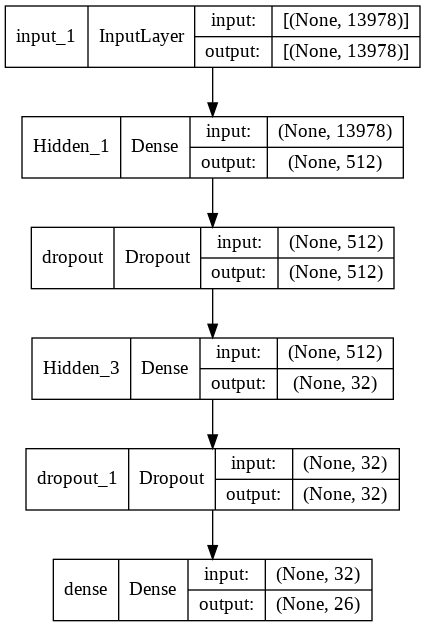

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 150
batch_size = 2048
# batch_size = tf_train_nn.shape[0]

model.fit(tf_train_nn, Y_tf_train_nn, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/150
10/10 [==============================] - 2s 68ms/step - loss: 0.6383 - accuracy: 0.0305 - val_loss: 0.5219 - val_accuracy: 0.0204
Epoch 2/150
10/10 [==============================] - 0s 43ms/step - loss: 0.4358 - accuracy: 0.0272 - val_loss: 0.3219 - val_accuracy: 0.0204
Epoch 3/150
10/10 [==============================] - 0s 45ms/step - loss: 0.2870 - accuracy: 0.0290 - val_loss: 0.2381 - val_accuracy: 0.0204
Epoch 4/150
10/10 [==============================] - 0s 43ms/step - loss: 0.2277 - accuracy: 0.0297 - val_loss: 0.2025 - val_accuracy: 0.0204
Epoch 5/150
10/10 [==============================] - 0s 46ms/step - loss: 0.1992 - accuracy: 0.0290 - val_loss: 0.1831 - val_accuracy: 0.0204
Epoch 6/150
10/10 [==============================] - 0s 44ms/step - loss: 0.1825 - accuracy: 0.0297 - val_loss: 0.1715 - val_accuracy: 0.0204
Epoch 7/150
10/10 [==============================] - 0s 45ms/step - loss: 0.1728 - accuracy: 0.0364 - val_loss: 0.1643 - val_accuracy: 0.0204
Epoch 

In [ ]:
y_pred = model.predict(tf_test_nn)

In [ ]:
Y_tf_test_nn

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [ ]:
nn_faculty_labels = list(map(np.argmax, Y_tf_test_nn))
nn_faculty_pred = list(map(np.argmax, y_pred))

precision, recall, f1, _ = precision_recall_fscore_support(nn_faculty_labels, nn_faculty_pred, average="macro")
acc = accuracy_score(nn_faculty_labels, nn_faculty_pred)

print(json.dumps({
    'accuracy': acc,
    'f1': f1,
    'precision': precision,
    'recall': recall
}, indent=4))

{
    "accuracy": 0.7561188811188811,
    "f1": 0.5997095697806403,
    "precision": 0.6998982125604563,
    "recall": 0.5800505895465361
}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### TF-IDF Neural network - predict study program
tf_train_program, tf_test_program, Y_tf_train_program, Y_tf_test_program

In [ ]:
tf_train_program_nn = tf_train_program.toarray()

In [ ]:
print(tf_train_program_nn.shape)
print(Y_tf_train_program.shape)

(10394, 11069)
(10394, 483)


In [ ]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras import regularizers

input = Input(shape=(tf_train_program.shape[1], ))
x = Dense(1024, activation="relu", name='Hidden_1')(input)
x = Dropout(0.4)(x)
# x = Dense(512, activation="relu", name='Hidden_2')(x)
# x = Dropout(0.2)(x)
# x = Dense(512, activation="relu", name='Hidden_3')(x)
# x = Dropout(0.2)(x)
output = Dense(Y_tf_train_program.shape[1], activation="sigmoid",)(x)

model = tf.keras.Model(inputs=input, outputs=output, name="TF-IDF_NN")

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), metrics=['accuracy'])

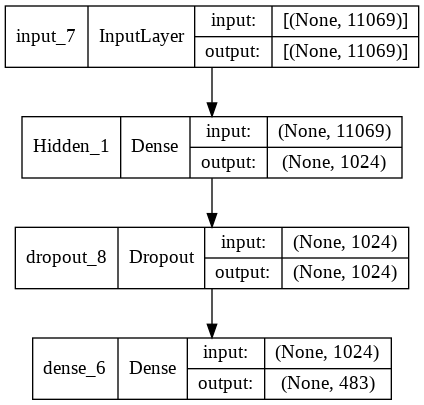

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 10
batch_size = 2048
# batch_size = tf_train_nn.shape[0]

model.fit(tf_train_program_nn, Y_tf_train_program, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/10
5/5 [==============================] - 1s 163ms/step - loss: 0.5015 - accuracy: 0.0012 - val_loss: 0.0488 - val_accuracy: 9.6154e-04
Epoch 2/10
5/5 [==============================] - 0s 95ms/step - loss: 0.0316 - accuracy: 0.0045 - val_loss: 0.0379 - val_accuracy: 0.0260
Epoch 3/10
5/5 [==============================] - 0s 92ms/step - loss: 0.0469 - accuracy: 0.0192 - val_loss: 0.0552 - val_accuracy: 0.0260
Epoch 4/10
5/5 [==============================] - 0s 86ms/step - loss: 0.0597 - accuracy: 0.0195 - val_loss: 0.0600 - val_accuracy: 0.0260
Epoch 5/10
5/5 [==============================] - 0s 87ms/step - loss: 0.0612 - accuracy: 0.0195 - val_loss: 0.0565 - val_accuracy: 0.0183
Epoch 6/10
5/5 [==============================] - 0s 87ms/step - loss: 0.0556 - accuracy: 0.0144 - val_loss: 0.0495 - val_accuracy: 0.0077
Epoch 7/10
5/5 [==============================] - 0s 92ms/step - loss: 0.0472 - accuracy: 0.0067 - val_loss: 0.0416 - val_accuracy: 0.0202
Epoch 8/10
5/5 [======

### Thai2Fit Neural network - predict study program
t2f_train_program, t2f_program, Y_t2f_test_program, Y_t2f_program

In [ ]:
# tf_train_program_nn = tf_train_program.toarray()

In [ ]:
print(t2f_train_program.shape)
print(Y_t2f_test_program.shape)

(10394, 300)
(10394, 483)


In [ ]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras import regularizers

input = Input(shape=(t2f_train_program.shape[1], ))
# x = Dense(512, activation="relu", name='Hidden_1')(input)
# x = Dropout(0.1)(x)
# x = Dense(512, activation="relu", name='Hidden_2')(x)
# x = Dropout(0.2)(x)
# x = Dense(512, activation="relu", name='Hidden_3')(x)
x = Dropout(0.2)(input)
output = Dense(Y_t2f_test_program.shape[1], activation="sigmoid",)(x)

model = tf.keras.Model(inputs=input, outputs=output, name="TF-IDF_NN")

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), metrics=['accuracy'])

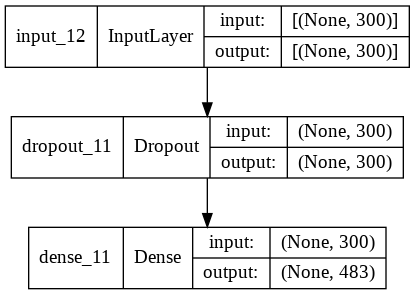

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 100
batch_size = 2048
# batch_size = tf_train_nn.shape[0]

model.fit(t2f_train_program, Y_t2f_test_program, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/100
5/5 [==============================] - 0s 45ms/step - loss: 0.0107 - accuracy: 0.4845 - val_loss: 0.0145 - val_accuracy: 0.2788
Epoch 2/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0107 - accuracy: 0.4833 - val_loss: 0.0145 - val_accuracy: 0.2798
Epoch 3/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0107 - accuracy: 0.4886 - val_loss: 0.0145 - val_accuracy: 0.2798
Epoch 4/100
5/5 [==============================] - 0s 16ms/step - loss: 0.0106 - accuracy: 0.4917 - val_loss: 0.0145 - val_accuracy: 0.2788
Epoch 5/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0106 - accuracy: 0.4897 - val_loss: 0.0145 - val_accuracy: 0.2808
Epoch 6/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0107 - accuracy: 0.4912 - val_loss: 0.0145 - val_accuracy: 0.2808
Epoch 7/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0107 - accuracy: 0.4882 - val_loss: 0.0145 - val_accuracy: 0.2808
Epoch 8/100
5/5 [===

### LSTM - predict study program
X_train, X_test, Y_train_program, Y_test_program

In [ ]:
X_train = np.array(X_train)

In [ ]:
print(X_train.shape)
print(Y_train_program.shape)

(10394, 305)
(10394, 483)


In [ ]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras import regularizers

# input = Input(shape=(X_train.shape[1], ))
# x = Dense(1024, activation="relu", name='Hidden_1')(input)
# x = Dropout(0.4)(x)
# # x = Dense(512, activation="relu", name='Hidden_2')(x)
# # x = Dropout(0.2)(x)
# # x = Dense(512, activation="relu", name='Hidden_3')(x)
# # x = Dropout(0.2)(x)
# output = Dense(Y_test_program.shape[1], activation="sigmoid",)(x)

# model = tf.keras.Model(inputs=input, outputs=output, name="TF-IDF_NN")


model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1], mask_zero=True))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(Y_test_program.shape[1], activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

# epochs = 5
# batch_size = 2048

# history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

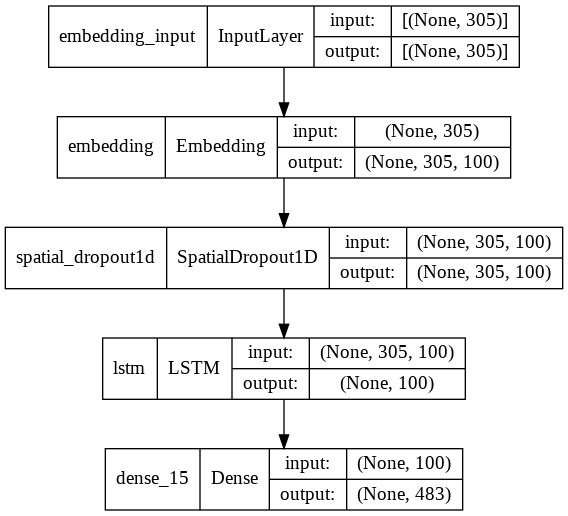

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 100
batch_size = 512
# batch_size = tf_train_nn.shape[0]

model.fit(X_train, Y_train_program, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/100
19/19 [==============================] - 52s 3s/step - loss: 0.0590 - accuracy: 0.0025 - val_loss: 0.0315 - val_accuracy: 0.0019
Epoch 2/100
19/19 [==============================] - 52s 3s/step - loss: 0.0284 - accuracy: 0.0025 - val_loss: 0.0247 - val_accuracy: 0.0019
Epoch 3/100
19/19 [==============================] - 51s 3s/step - loss: 0.0248 - accuracy: 0.0025 - val_loss: 0.0231 - val_accuracy: 0.0019
Epoch 4/100
19/19 [==============================] - 52s 3s/step - loss: 0.0236 - accuracy: 0.0159 - val_loss: 0.0223 - val_accuracy: 0.0260
Epoch 5/100
19/19 [==============================] - 52s 3s/step - loss: 0.0229 - accuracy: 0.0195 - val_loss: 0.0218 - val_accuracy: 0.0260
Epoch 6/100
19/19 [==============================] - 52s 3s/step - loss: 0.0225 - accuracy: 0.0195 - val_loss: 0.0215 - val_accuracy: 0.0260
Epoch 7/100
19/19 [==============================] - 52s 3s/step - loss: 0.0221 - accuracy: 0.0195 - val_loss: 0.0212 - val_accuracy: 0.0260
Epoch 8/100
1

### LSTM
X_train, X_test, Y_train, Y_test

In [ ]:
model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1], mask_zero=True))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(Y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
epochs = 100
batch_size = 2048

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/100
10/10 [==============================] - 15s 1s/step - loss: 3.2502 - accuracy: 0.1278 - val_loss: 3.2372 - val_accuracy: 0.1841
Epoch 2/100
10/10 [==============================] - 11s 1s/step - loss: 3.2211 - accuracy: 0.1761 - val_loss: 3.1956 - val_accuracy: 0.1729
Epoch 3/100
10/10 [==============================] - 12s 1s/step - loss: 3.1618 - accuracy: 0.1687 - val_loss: 3.1462 - val_accuracy: 0.1734
Epoch 4/100
10/10 [==============================] - 11s 1s/step - loss: 3.1041 - accuracy: 0.1782 - val_loss: 3.0904 - val_accuracy: 0.2025
Epoch 5/100
10/10 [==============================] - 12s 1s/step - loss: 3.0439 - accuracy: 0.2124 - val_loss: 3.0325 - val_accuracy: 0.2176
Epoch 6/100
10/10 [==============================] - 11s 1s/step - loss: 2.9739 - accuracy: 0.2265 - val_loss: 2.9645 - val_accuracy: 0.2166
Epoch 7/100
10/10 [==============================] - 11s 1s/step - loss: 2.8922 - accuracy: 0.2351 - val_loss: 2.8932 - val_accuracy: 0.2317
Epoch 8/100
1

In [ ]:
model.evaluate(X_test, Y_test)

In [ ]:
for x in X_test[0]:
  if x != 0:
    key =  list(word_index.keys())[list(word_index.values()).index(x)]
    print(key, end='')

In [ ]:
word_index

In [ ]:
model.predict(X_test[0].reshape(1, X_test.shape[1]))

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
lstm_faculty_labels = list(map(np.argmax, Y_test))
lstm_faculty_pred = list(map(np.argmax, y_pred))

precision, recall, f1, _ = precision_recall_fscore_support(lstm_faculty_labels, lstm_faculty_pred, average="macro")
acc = accuracy_score(lstm_faculty_labels, lstm_faculty_pred)

print(json.dumps({
    'accuracy': acc,
    'f1': f1,
    'precision': precision,
    'recall': recall
}, indent=4))

In [ ]:
# from keras import backend as K
# K.clear_session()

In [ ]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

### Wangchan berta

#### Train model

In [92]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)

    # classification_report_result = classification_report(labels, preds, target_names=target_names)

    # print(classification_report_result)
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        # 'report': classification_report_result
    }

In [93]:
training_args = TrainingArguments(
    output_dir='./faculty_classification',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./faculty_classification_logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy='epoch'
)

In [94]:
revision = None
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=label_number,
    revision=revision
)

Some weights of the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wa

In [127]:
trainer = Trainer(
    model=model_check,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,        # evaluation dataset
    compute_metrics=compute_metrics,
)

In [96]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.869189,0.790174,0.781906,0.623785,0.639068,0.635631
2,0.543286,0.684007,0.810315,0.698512,0.757799,0.692898
3,0.644385,0.672884,0.808566,0.743775,0.725577,0.779081
4,0.544092,0.697626,0.827797,0.742832,0.757289,0.740549
5,0.123901,0.727798,0.837413,0.761598,0.788715,0.749718
6,0.110059,0.824323,0.840472,0.762823,0.798786,0.745445
7,0.117969,0.876947,0.845280,0.763108,0.775658,0.760861
8,0.037549,0.956392,0.844406,0.770667,0.776231,0.772445
9,0.030176,0.942347,0.850962,0.777142,0.778603,0.787784
10,0.031445,0.964699,0.851836,0.779117,0.778762,0.791998


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=12870, training_loss=0.3444544225305944)

In [91]:
# torch.cuda.empty_cache()
# import gc
# del trainer
# gc.collect()

3707

In [99]:
for name, param in model.named_parameters():
  print('check', name, param.requires_grad)

check roberta.embeddings.word_embeddings.weight True
check roberta.embeddings.position_embeddings.weight True
check roberta.embeddings.token_type_embeddings.weight True
check roberta.embeddings.LayerNorm.weight True
check roberta.embeddings.LayerNorm.bias True
check roberta.encoder.layer.0.attention.self.query.weight True
check roberta.encoder.layer.0.attention.self.query.bias True
check roberta.encoder.layer.0.attention.self.key.weight True
check roberta.encoder.layer.0.attention.self.key.bias True
check roberta.encoder.layer.0.attention.self.value.weight True
check roberta.encoder.layer.0.attention.self.value.bias True
check roberta.encoder.layer.0.attention.output.dense.weight True
check roberta.encoder.layer.0.attention.output.dense.bias True
check roberta.encoder.layer.0.attention.output.LayerNorm.weight True
check roberta.encoder.layer.0.attention.output.LayerNorm.bias True
check roberta.encoder.layer.0.intermediate.dense.weight True
check roberta.encoder.layer.0.intermediate.den

In [128]:
result_eval = trainer.evaluate()

In [129]:
import json

print(json.dumps(result_eval, indent=4))

{
    "eval_loss": 0.9646991491317749,
    "eval_accuracy": 0.8518356643356644,
    "eval_f1": 0.7791171681418476,
    "eval_precision": 0.7787616402930839,
    "eval_recall": 0.7919981879519274
}


#### Analyse WangChan result

In [126]:
model_check = AutoModelForSequenceClassification.from_pretrained("new5558/wangchan-course")

In [133]:
text = process_transformers("มูลเหตุ อิทธิพลต่างๆ และแนวความคิดในการสร้างสรรค์งานศิลปะและสถาปัตยกรรม การวิเคราะห์และวิจารณ์ผลงานศิลปะและสถาปัตยกรรม ประวัติศาสตร์ศิลปะและและสถาปัตยกรรมตะวันตกโดยสังเขป ตั้งแต่สมัยก่อนประวัติศาสตร์จนถึงคริสต์ศตวรรษที่ 20")

device = "cuda"

_inputs = tokenizer(text, return_tensors="pt").to(device)
# _inputs = tokenizer(text, return_tensors="pt")

outputs = model_check(**_inputs)

outputs

(tensor([[ 1.8677, -0.3342, -1.3128,  1.0767, -1.0225, -0.3569, 10.3153, -0.2828,
           2.4082, -0.4426,  0.0517, -1.7291, -1.9308, -1.3181, -1.0596, -0.8833,
           0.2908,  0.2941, -1.9218,  0.0291,  0.9976, -0.2248, -0.9278, -1.7475,
          -2.3012, -1.6214]], device='cuda:0', grad_fn=<AddmmBackward>),)

In [134]:
from torch.nn.functional import softmax
prediction_result = softmax(outputs[0], dim=1).cpu().data.numpy().round(2)
np.argmax(prediction_result)

6

In [136]:
softmax(outputs[0], dim=1).cpu().data.numpy().round(3)

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.999, 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]],
      dtype=float32)

In [137]:
enc.inverse_transform([[6]])

array([['25']], dtype=object)

In [151]:
from transformers import TextClassificationPipeline

pipeline = TextClassificationPipeline(model = model_check, tokenizer = tokenizer, device=0)

In [152]:
import transformers
import shap

# explain the model on two sample inputs
explainer = shap.Explainer(pipeline) 
shap_values = explainer([process_transformers("มูลเหตุ อิทธิพลต่างๆ และแนวความคิดในการสร้างสรรค์งานศิลปะและสถาปัตยกรรม การวิเคราะห์และวิจารณ์ผลงานศิลปะและสถาปัตยกรรม ประวัติศาสตร์ศิลปะและและสถาปัตยกรรมตะวันตกโดยสังเขป ตั้งแต่สมัยก่อนประวัติศาสตร์จนถึงคริสต์ศตวรรษที่ 20")])

# visualize the first prediction's explanation for the POSITIVE output class
shap.plots.text(shap_values[0, :, int(enc.transform([['25']])[0][0])])

In [153]:
shap.plots.text(shap_values[0, :, int(enc.transform([['22']])[0][0])])

In [154]:
shap.plots.text(shap_values[0, :, int(enc.transform([['35']])[0][0])])

In [155]:
index =  1020#@param {type:"integer"}

text = val_texts[index]
label = val_labels[index]
print(f"text: {text}")
print(f"label: {label}")
print(f"prediction: {pipeline(text)[0]}")
print(f"label inversed: {enc.inverse_transform([label])}")

# explain the model on two sample inputs
explainer = shap.Explainer(pipeline) 
shap_values = explainer([process_transformers(text)])

# visualize the first prediction's explanation for the POSITIVE output class
shap.plots.text(shap_values[0, :, int(label)])

text: การศึกษาวิเคราะห์ในหัวข้อเฉพาะเรื่องด้านภาษา<_>ดนตรี<_>ศิลปะ<_>ภาพยนตร์<_>ประวัติศาสตร์<_>หรือปรัชญาของอิตาลี
label: [3.]
prediction: {'label': 'LABEL_3', 'score': 0.9998988509178162}
label inversed: [['22']]


## Use trained model to embed text

In [65]:
text = "มูลเหตุ อิทธิพลต่างๆ และแนวความคิดในการสร้างสรรค์งานศิลปะและสถาปัตยกรรม การวิเคราะห์และวิจารณ์ผลงานศิลปะและสถาปัตยกรรม ประวัติศาสตร์ศิลปะและและสถาปัตยกรรมตะวันตกโดยสังเขป ตั้งแต่สมัยก่อนประวัติศาสตร์จนถึงคริสต์ศตวรรษที่ 20"

In [66]:
def extract_last_k(input_text, feature_extractor, last_k=4):
    hidden_states = feature_extractor(input_text)[0]
    last_k_layers = [hidden_states[i] for i in [-i for i in range(1,last_k+1)]]
    cat_hidden_states = sum(last_k_layers, [])
    return np.array(cat_hidden_states)

In [67]:
# from transformers import FeatureExtractionPipeline
from transformers import pipeline

feature_pipeline = pipeline(task='feature-extraction',
         tokenizer=tokenizer,
         model ="new5558/wangchan-course",
         device = 0,
         revision = 'main')
# feature_pipeline = FeatureExtractionPipeline(model = "new5558/wangchan-course", tokenizer = tokenizer, device=0)

Some weights of CamembertModel were not initialized from the model checkpoint at new5558/wangchan-course and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of CamembertModel were not initialized from the model checkpoint at new5558/wangchan-course and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
feature = feature_pipeline(process_transformers(text))
np.array(feature).shape

(1, 51, 768)

In [69]:
final_feature = extract_last_k(process_transformers(text), feature_pipeline)

In [75]:
final_feature.shape

(3072,)

In [70]:
features_train = []

for textin in tqdm(train_texts):
  features_train.append(extract_last_k(process_transformers(text), feature_pipeline))

  0%|          | 0/20584 [00:00<?, ?it/s]

In [71]:
features_test = []

for textin in tqdm(val_texts):
  features_test.append(extract_last_k(process_transformers(text), feature_pipeline))

  0%|          | 0/2288 [00:00<?, ?it/s]

In [72]:
# features_train_df = pd.DataFrame(features_train)
# features_test_df = pd.DataFrame(features_test)

In [73]:
# save numpy array as npz file
from numpy import asarray
from numpy import savez_compressed
# define data
features_train_array = asarray(features_train)
features_test_array = asarray(features_test)
# save to npy file
savez_compressed('./data/features_train_array.npz', features_train_array)
savez_compressed('./data/features_test_array.npz', features_test_array)

In [ ]:
# # load numpy array from npz file
# from numpy import load
# # load dict of arrays
# dict_data = load('data.npz')
# # extract the first array
# data = dict_data['arr_0']
# # print the array
# print(data)

In [81]:
features_train_array.shape

(20584, 3072)

In [ ]:
train_labels.shape

In [ ]:
from sklearn import svm

clf = svm.SVC(verbose=True)
clf.fit(features_train_array, train_labels.flatten())

[LibSVM]

Process ForkPoolWorker-28:
Process ForkPoolWorker-25:
Process ForkPoolWorker-24:
Process ForkPoolWorker-21:
Process ForkPoolWorker-23:
Process ForkPoolWorker-26:
Process ForkPoolWorker-27:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-22:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessin

In [ ]:
Y_pred = clf.predict(features_test_df)
precision, recall, f1, _ = precision_recall_fscore_support(val_labels.flatten(), Y_pred, average="macro")
acc = accuracy_score(val_labels.flatten(), Y_pred)

print(json.dumps({
    'accuracy': acc,
    'f1': f1,
    'precision': precision,
    'recall': recall
}, indent=4))

In [86]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(features_train_df, train_labels.flatten())

KNeighborsClassifier()

In [87]:
Y_pred = neigh.predict(features_test_df)
precision, recall, f1, _ = precision_recall_fscore_support(val_labels.flatten(), Y_pred, average="macro")
acc = accuracy_score(val_labels.flatten(), Y_pred)

print(json.dumps({
    'accuracy': acc,
    'f1': f1,
    'precision': precision,
    'recall': recall
}, indent=4))

{
    "accuracy": 0.03977272727272727,
    "f1": 0.0029424127784783522,
    "precision": 0.0015297202797202797,
    "recall": 0.038461538461538464
}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
